In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

#You can import other libraries if you want

In [2]:
###### DO NOT MODIFY THIS PART
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed) # fix your random seed : In same model, you produce the same result
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
######

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('./drive/MyDrive/train')
!ls

Mounted at /content/drive
artists.csv  images  soth


In [4]:
artists = pd.read_csv('artists.csv') # your own directory
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe
artists_top = artists[artists['paintings'] >= 0].reset_index()
artists_top = artists_top[['name', 'paintings']]

updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [5]:
# Explore images of top artists
images_dir = './images' #Type Your Own Data Directory
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):  # images_idr: directory folder // name: label (y)
        print("find -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

find --> ./images/Vincent_van_Gogh
find --> ./images/Edgar_Degas
find --> ./images/Pablo_Picasso
find --> ./images/Pierre-Auguste_Renoir
find --> ./images/Albrecht_Dürer
find --> ./images/Paul_Gauguin
find --> ./images/Francisco_Goya
find --> ./images/Rembrandt
find --> ./images/Alfred_Sisley
find --> ./images/Titian
find --> ./images/Marc_Chagall


In [6]:
batch_size = 32
input_shape = (224,224,3)
n_classes = artists_top.shape[0]

#Image data generate with validation data fraction of 0.2 and data rescale 1/255.
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3099 images belonging to 11 classes.
Found 769 images belonging to 11 classes.
Total number of batches = 96 and 24


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense

def residual_block(x, filters, kernel_size=3, stride=1):
    y = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    y = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)

    # Adjusting the shortcut connection for the correct stride
    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=1, strides=stride, padding='valid')(x)
        x = BatchNormalization()(x)

    y = Add()([x, y])
    y = ReLU()(y)
    return y

def build_model(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)

    # Global Average Pooling
    x = AveragePooling2D(pool_size=(x.shape[1], x.shape[2]))(x)
    x = Flatten()(x)

    # Fully Connected Layers
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

# Build the ResNet-18 model
model = build_model(input_shape=input_shape, num_classes=n_classes)

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
#training

n_epoch = 50

history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch) #you can add kwargs if you want

<ipython-input-8-5a3465271696>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/50
96/96 [==============================] - 715s 7s/step - loss: 2.8959 - accuracy: 0.2214 - val_loss: 3.0514 - val_accuracy: 0.1888
Epoch 2/50
96/96 [==============================] - 98s 1s/step - loss: 2.3875 - accuracy: 0.2736 - val_loss: 4.9744 - val_accuracy: 0.0951
Epoch 3/50
96/96 [==============================] - 98s 1s/step - loss: 2.2217 - accuracy: 0.3189 - val_loss: 2.5528 - val_accuracy: 0.2448
Epoch 4/50
96/96 [==============================] - 97s 1s/step - loss: 2.0301 - accuracy: 0.3446 - val_loss: 1.9985 - val_accuracy: 0.3411
Epoch 5/50
96/96 [==============================] - 96s 1000ms/step - loss: 2.0185 - accuracy: 0.3469 - val_loss: 3.1854 - val_accuracy: 0.2070
Epoch 6/50
96/96 [==============================] - 99s 1s/step - loss: 1.8888 - accuracy: 0.3740 - val_loss: 2.9717 - val_accuracy: 0.2878
Epoch 7/50
96/96 [==============================] - 99s 1s/step - loss: 1.8192 - accuracy: 0.3838 - val_loss: 11.3829 - val_accuracy: 0.1029
Epoch 8/50
96/

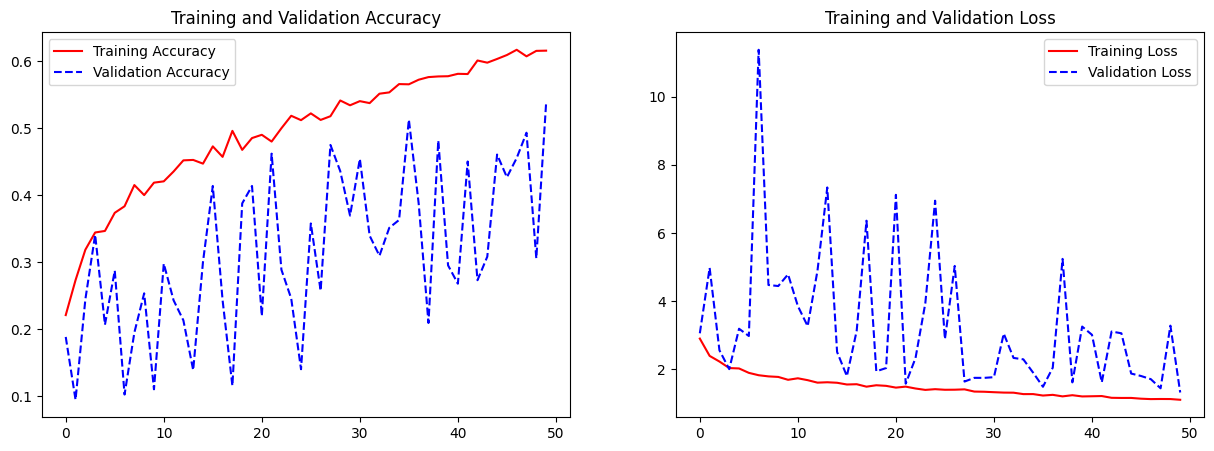

In [11]:
his = {}
his['loss'] = history.history['loss']
his['accuracy'] = history.history['accuracy']
his['val_loss'] = history.history['val_loss']
his['val_accuracy'] = history.history['val_accuracy']

# Plot the training graph
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))

    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')

    plt.show()

plot_training(his)

In [10]:
model.save("model")